In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from skforecast.utils import load_forecaster

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers,callbacks
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Input

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
pd.options.mode.chained_assignment = None  # default='warn'
# warnings.filterwarnings('ignore')

In [2]:
# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [4]:
# Carga de datos
# ==============================================================================
folder = "C:\\Users\\Martinejo\\Documents\\UMH\\INVESTIGACION\\MARGARITA_SALAS\\Sistema_Riego\\"
parametro = 'eto'
output=parametro
inputs_sen = [
          'fecha', 'eto','viento_med','precip','temp_med','hr_med','rad_med'
          ]
inputs_sat = [
          'date', 'ndvi_mean','ndwi_mean','ndmi_mean','gndvi_mean','evi_mean','evi2_mean','savi_mean'
          ]
usecols_sen = inputs_sen.copy()
usecols_sat = inputs_sat.copy()

datos_sen = pd.read_csv(folder + "agroclimatology_parcel_1_ORIGINAL" + ".csv",sep=',', usecols=usecols_sen)
datos_sat = pd.read_csv(folder + "teledeteccion_sentinel2_parcel_1" + ".csv",sep=',', usecols=usecols_sat)

datos_sen = datos_sen.drop_duplicates()
datos_sat = datos_sat.drop_duplicates()

In [5]:
datos = datos_sen.copy()

In [6]:
# Preparación del dato como serie temporal
# ==============================================================================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.rename(columns={'x': 'y'})
datos = datos.asfreq('D')
datos = datos.sort_index()

datos.info()

#datos = datos.iloc[254:]

datos.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 591 entries, 2022-01-10 to 2023-08-23
Freq: D
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eto         587 non-null    float64
 1   viento_med  587 non-null    float64
 2   precip      587 non-null    float64
 3   temp_med    587 non-null    float64
 4   hr_med      587 non-null    float64
 5   rad_med     587 non-null    float64
dtypes: float64(6)
memory usage: 32.3 KB


,eto,viento_med,precip,temp_med,hr_med,rad_med
fecha,,,,,,
2022-01-10,3.11,2.94,0.2,17.89,45.74,77.55
2022-01-11,0.58,0.10,2.7,11.23,84.39,38.57
2022-01-12,0.68,0.22,0.1,10.04,76.46,91.54
2022-01-13,0.82,0.55,2.2,9.09,75.15,101.53
2022-01-14,0.67,0.28,0.0,7.14,75.08,89.25


In [7]:
datos["eto"].isna().sum()

4

In [8]:
while datos["eto"].isna().sum() > 0:
    datos = datos.fillna(value=datos.shift(1))
    datos["eto"].isna().sum()

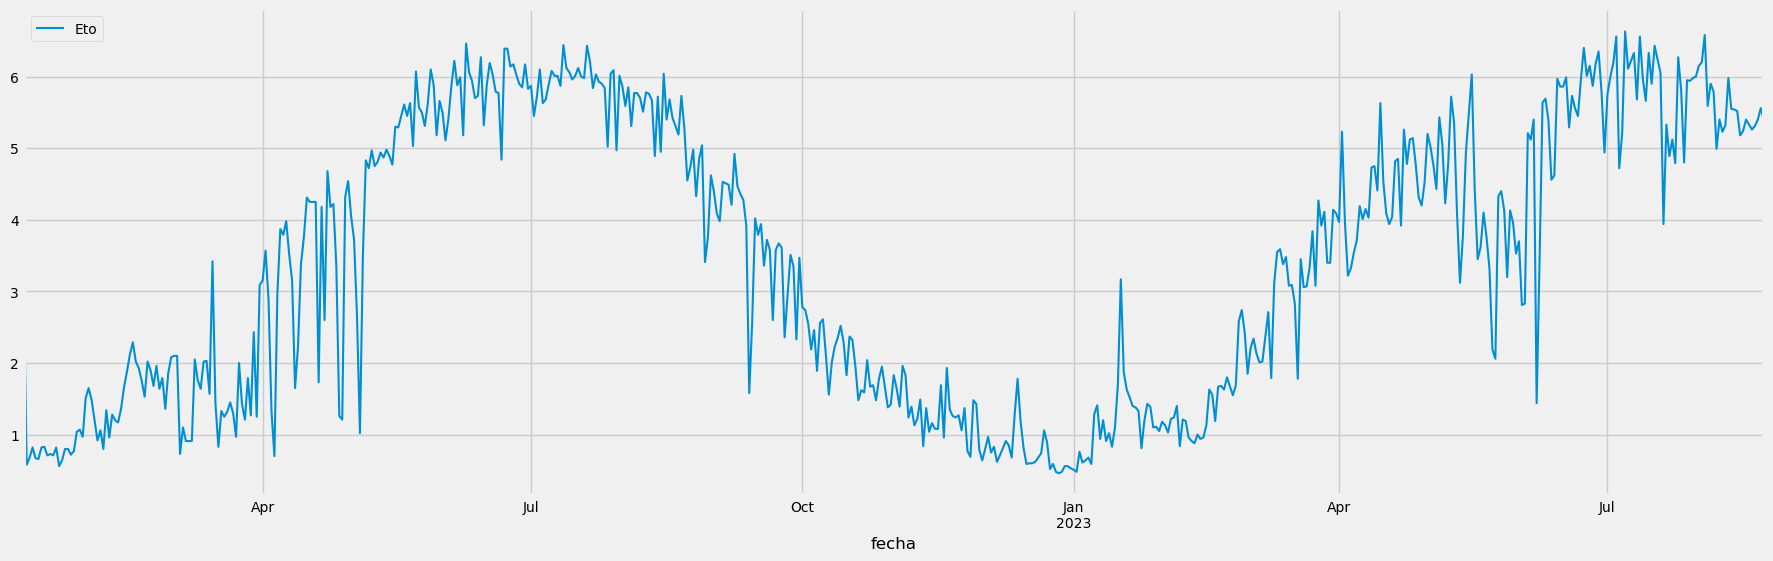

In [9]:
fig, ax = plt.subplots(figsize=(20, 6))
datos['eto'].plot(ax=ax, label='Eto')
#datos['ambiente'].plot(ax=ax, label='Ambiente')
#datos['nivel'].plot(ax=ax, label='Nivel')
ax.legend();

#COMENTAR ESTA LISTA PARA HACER EL ANÁLISIS CON LA PROPIA SERIE, Y NO CON LAS DIFERENCIAS
#datos = datos.diff().dropna()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 561 entries, 2022-01-10 to 2023-07-24
Freq: D
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eto         561 non-null    float64
 1   viento_med  561 non-null    float64
 2   precip      561 non-null    float64
 3   temp_med    561 non-null    float64
 4   hr_med      561 non-null    float64
 5   rad_med     561 non-null    float64
dtypes: float64(6)
memory usage: 30.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2023-07-25 to 2023-08-23
Freq: D
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eto         30 non-null     float64
 1   viento_med  30 non-null     float64
 2   precip      30 non-null     float64
 3   temp_med    30 non-null     float64
 4   hr_med      30 non-null     float64
 5   rad_med     30 non-null     float64
dtypes: float64(6)
memory usage: 1.6 KB


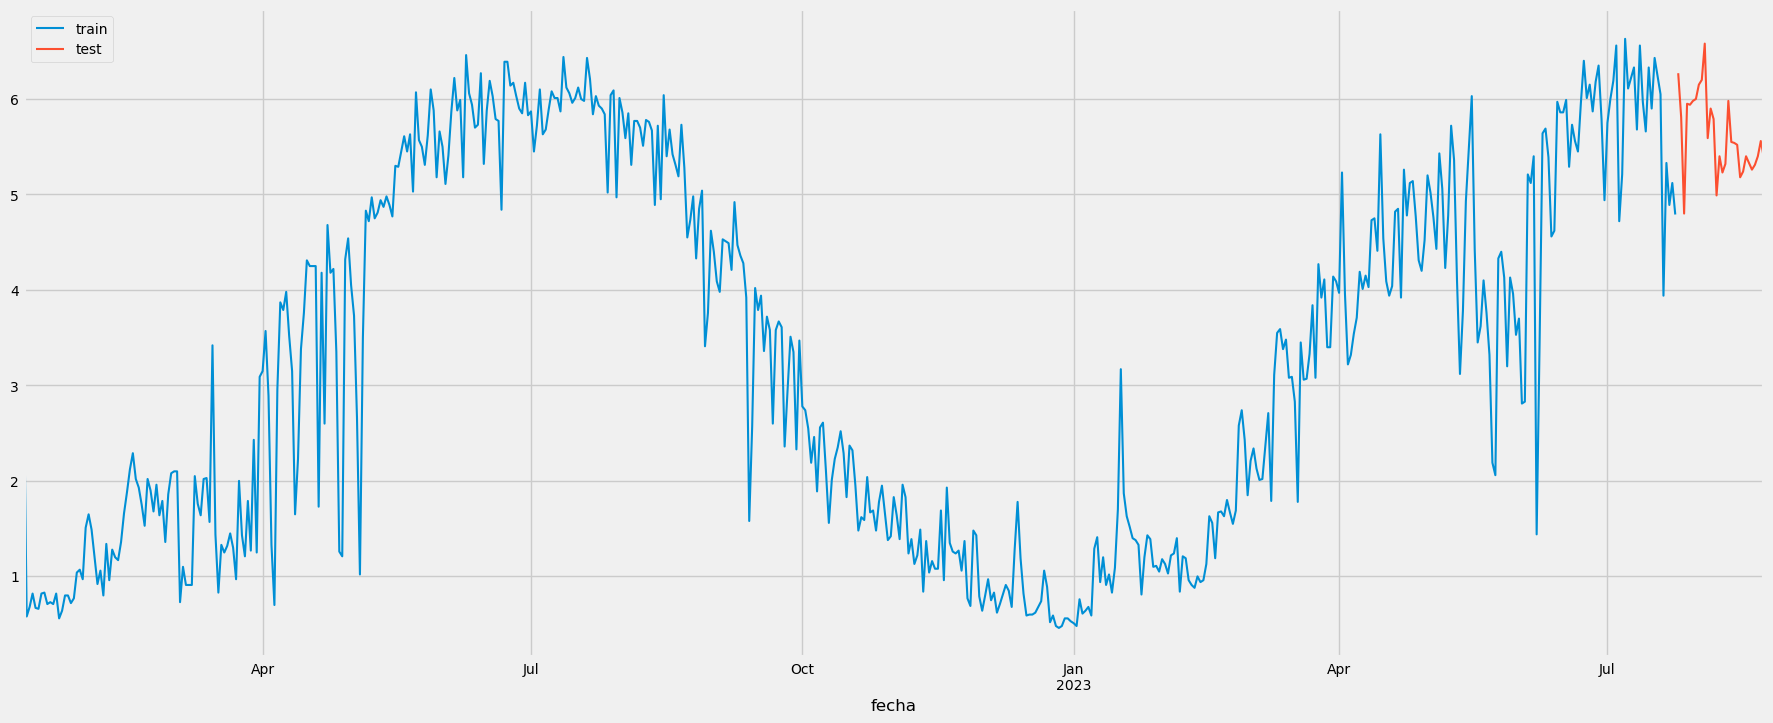

In [10]:
# Separación datos train-test
# ==============================================================================
steps = 30
df_train = datos[:-steps]
df_test  = datos[-steps:]

df_train.info()
df_test.info()

fig, ax = plt.subplots(figsize=(20, 8))
df_train['eto'].plot(ax=ax, label='train')
df_test['eto'].plot(ax=ax, label='test')
ax.legend();

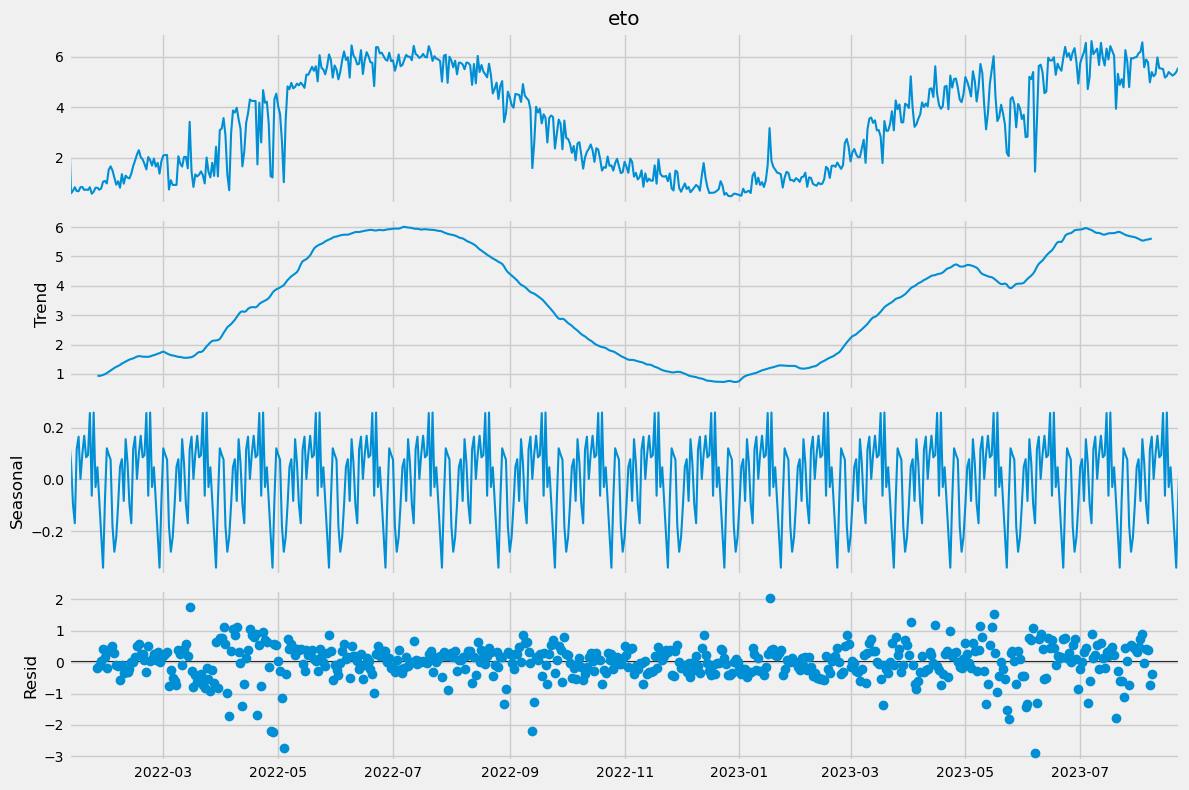

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose 
plt.rcParams["figure.figsize"] = (12,8)
a=seasonal_decompose(datos["eto"], model ="add", period=30)
a.plot();

In [12]:
#from pmdarima import auto_arima  
#modelo_auto=auto_arima(df_train['eto'],start_p=0,d=1,start_q=0,
#          max_p=4,max_d=2,max_q=4, m=24, seasonal=True,
#          error_action='warn',trace=True,
#          supress_warnings=True,stepwise=True,
#          random_state=20,n_fits=50)
#print(modelo_auto)

# 1. Autoregression (AR)

In [13]:
from statsmodels.tsa.ar_model import AutoReg
from random import random

def AR_model(train,test):
    # fit model
    model_AR = AutoReg(train["eto"], lags=30)
    model_AR_fit = model_AR.fit()
    # make prediction
    yhat=model_AR_fit.predict(len(train), len(train) + len(test) - 1)
    res=pd.DataFrame({"Pred":yhat, "ETO":test["eto"].values})
    return res
 
df_ret = AR_model(df_train, df_test)

Evaluation metric results:-
MSE: 1.3431014206632663
MAE: 1.1162307572727357
RMSE: 1.1589225257381386
MAPE: 19.65683375247655
R2: -7.218463110453319



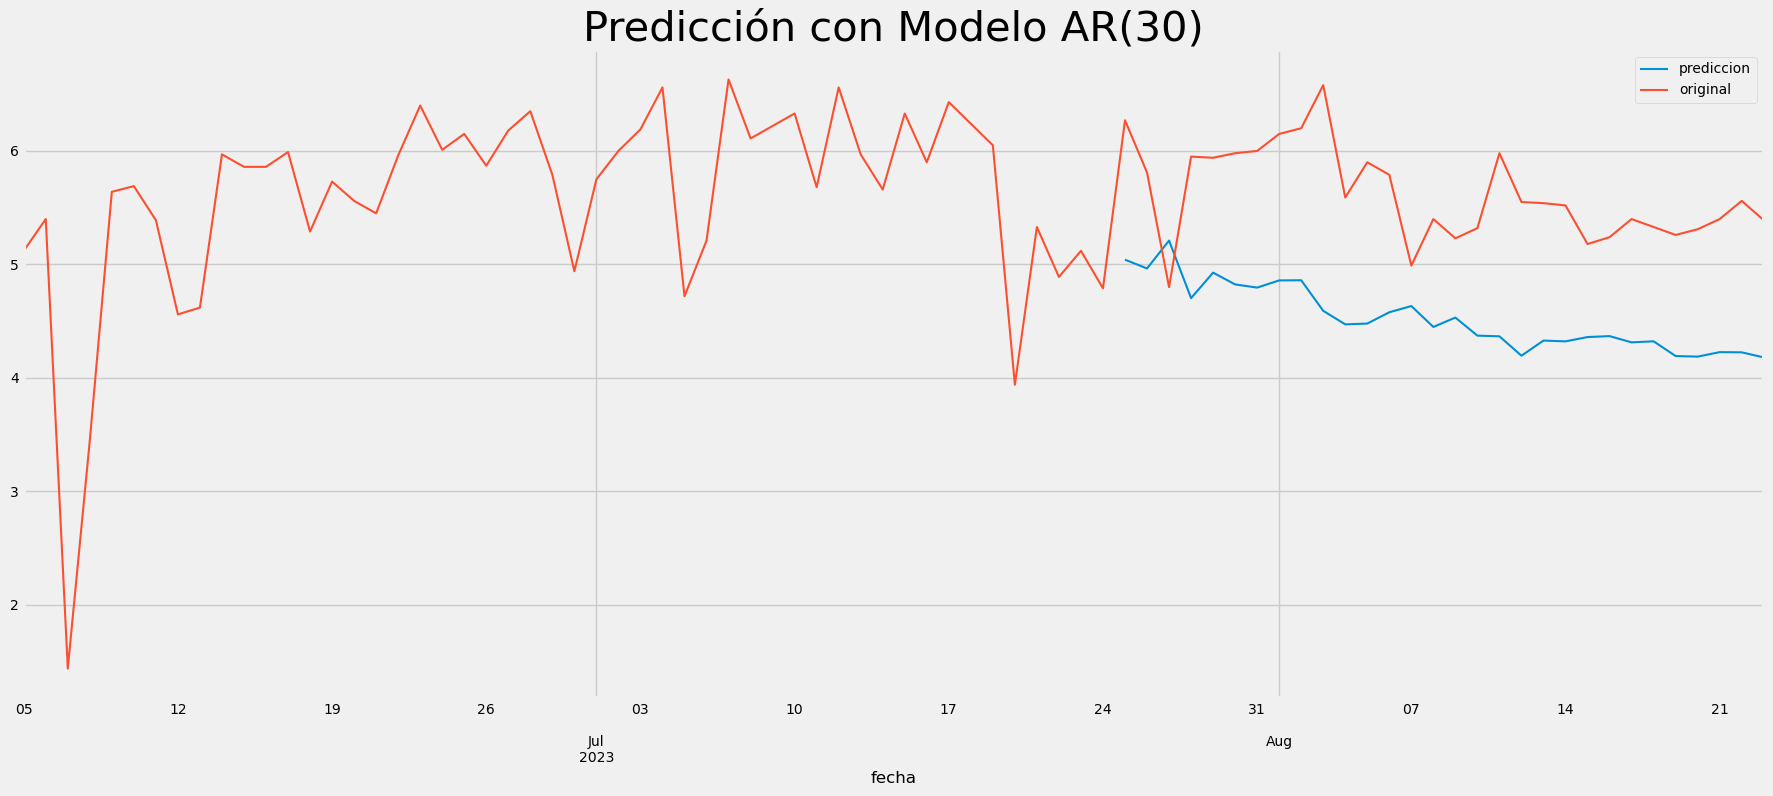

In [14]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.title("Predicción con Modelo AR(30)", fontsize=30);
#df_train['temperatura'].plot(ax=ax, label='train')
df_ret['Pred'].plot(ax=ax, label='prediccion')
datos["eto"].tail(50+steps).plot(ax=ax, label='original')
ax.legend();

evaluacion_metrica(df_test['eto'],df_ret['Pred'])

# 2. Seasonal Autoregressive Integrated Moving-Average (SARIMA)

In [15]:
#from pmdarima import auto_arima   

#modelo_auto=auto_arima(df_train["eto"],start_p=0,d=0,tart_q=0,
#          max_p=4,max_d=2,max_q=4, m=30, seasonal=True,
#          error_action='warn',trace=True,
#          supress_warnings=True,stepwise=True,
#          random_state=20,n_fits=50)

#print(modelo_auto)

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

def SARIMA_model(train,test):
    # fit model
    model_ARIMA = SARIMAX(train['eto'], order=(3, 0, 2), seasonal_order=(0,0,0,30))
    model__ARIMA_fit = model_ARIMA.fit(disp=False)
    # make prediction
    yhat = model__ARIMA_fit.predict(len(train), len(train) + len(test) -1 )
    res=pd.DataFrame({"Pred":yhat, "Act":test["eto"].values})
    return res

df_ret = SARIMA_model(df_train, df_test)

C:\Users\Martinejo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Martinejo\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Evaluation metric results:-
MSE: 0.4065095823720234
MAE: 0.5391764750943072
RMSE: 0.6375810398467189
MAPE: 9.245902178039863
R2: -1.4874398577587864



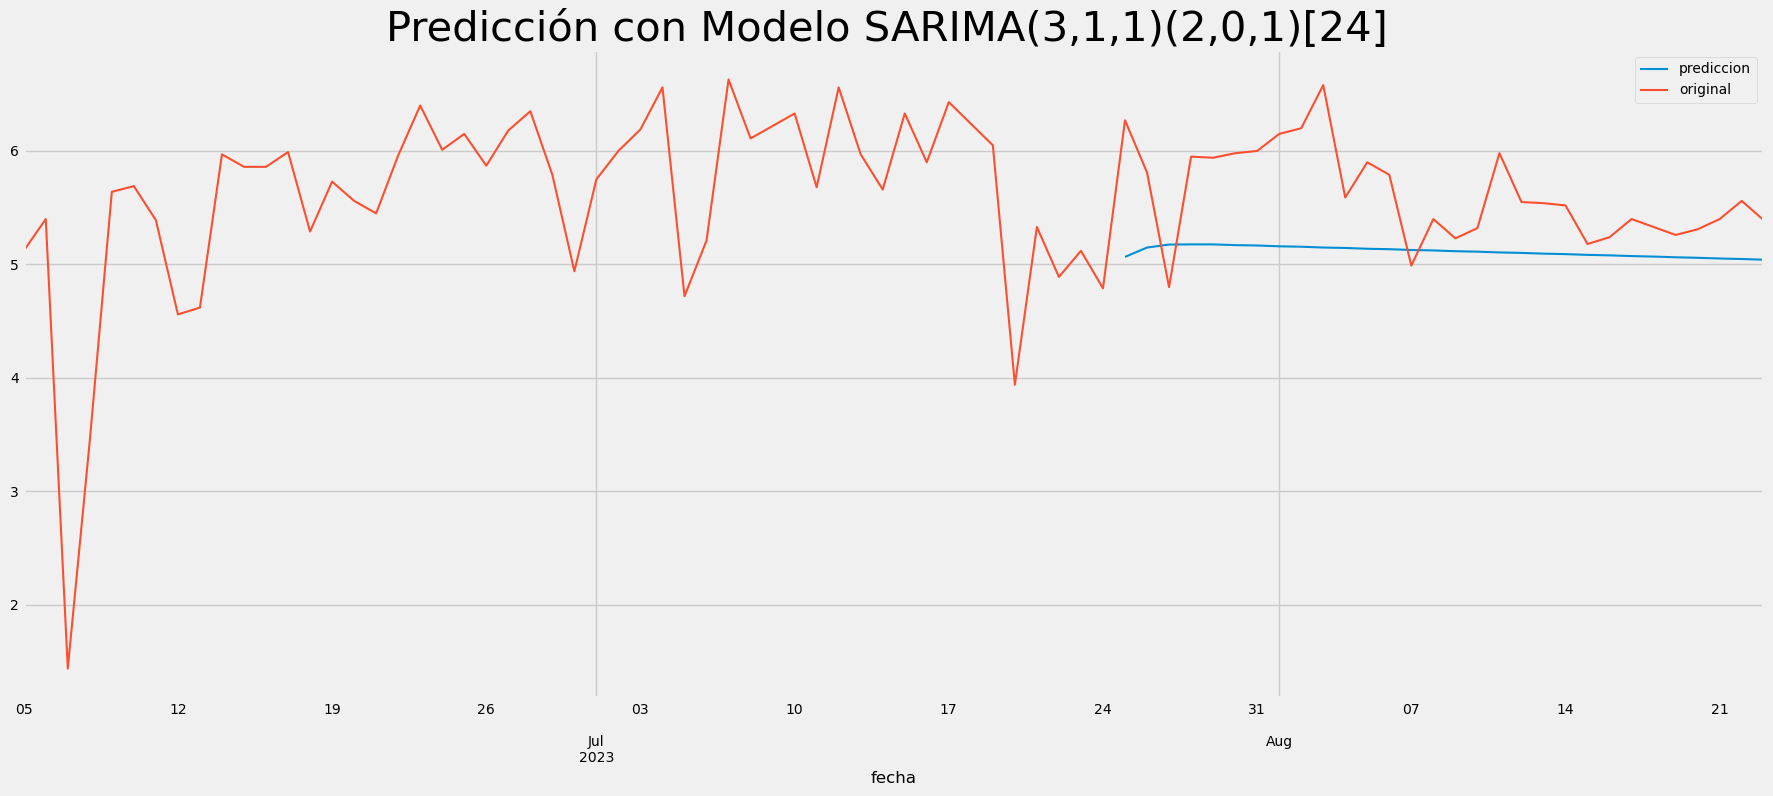

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.title("Predicción con Modelo SARIMA(3,1,1)(2,0,1)[24] ", fontsize=30);
#df_train['temperatura'].plot(ax=ax, label='train')
df_ret['Pred'].plot(ax=ax, label='prediccion')
datos["eto"].tail(50+steps).plot(ax=ax, label='original')
ax.legend();

evaluacion_metrica(y_true = df_test['eto'],y_pred = df_ret['Pred'])

## LSTM

1/1 [==============================] - 0s 15ms/step - loss: 0.0016
Fold 1 - Test Loss: 0.001581542193889618
1/1 [==============================] - 0s 109ms/step
Fold 1 - MSE: 0.06020760620709254
Fold 1 - MAE: 0.1911062698364259


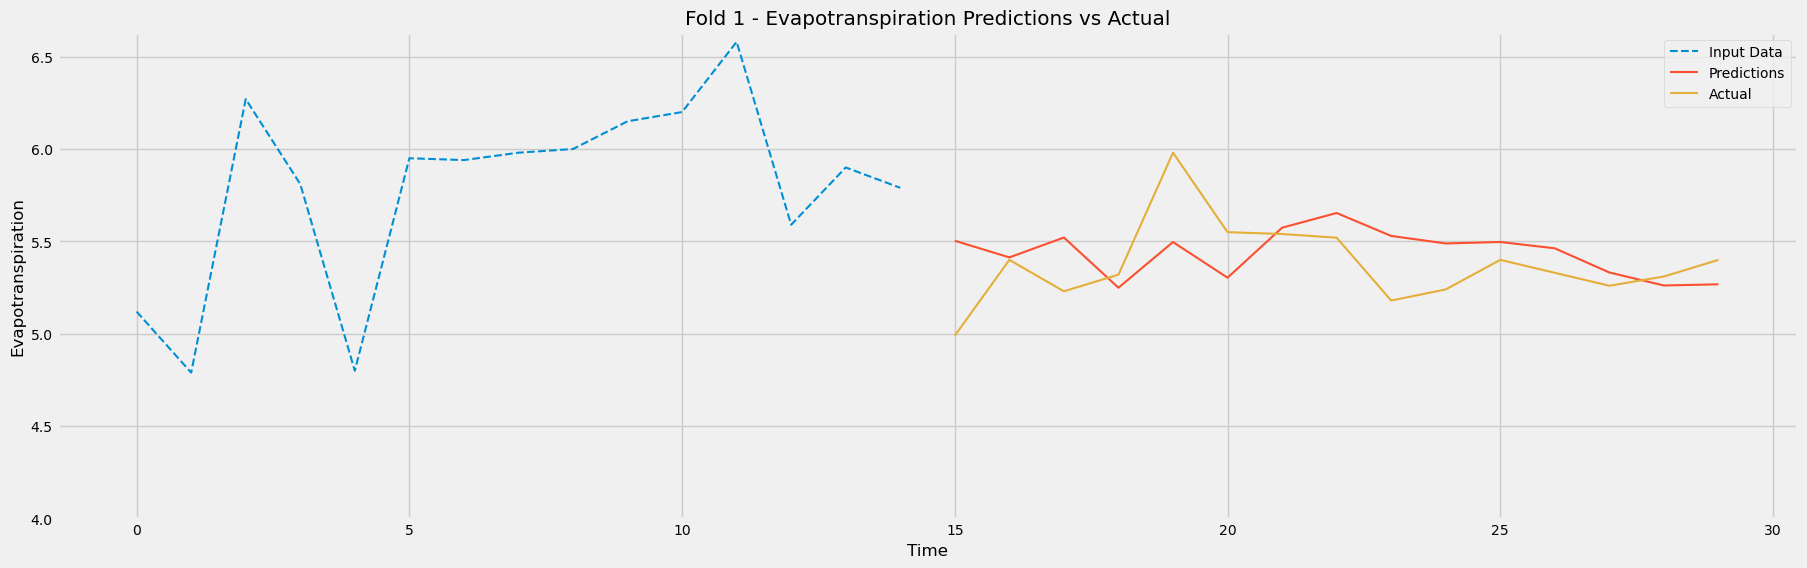

1/1 [==============================] - 0s 15ms/step - loss: 0.0014
Fold 2 - Test Loss: 0.0013527452247217298
1/1 [==============================] - 0s 13ms/step
Fold 2 - MSE: 0.051497545894147886
Fold 2 - MAE: 0.1804427146911621


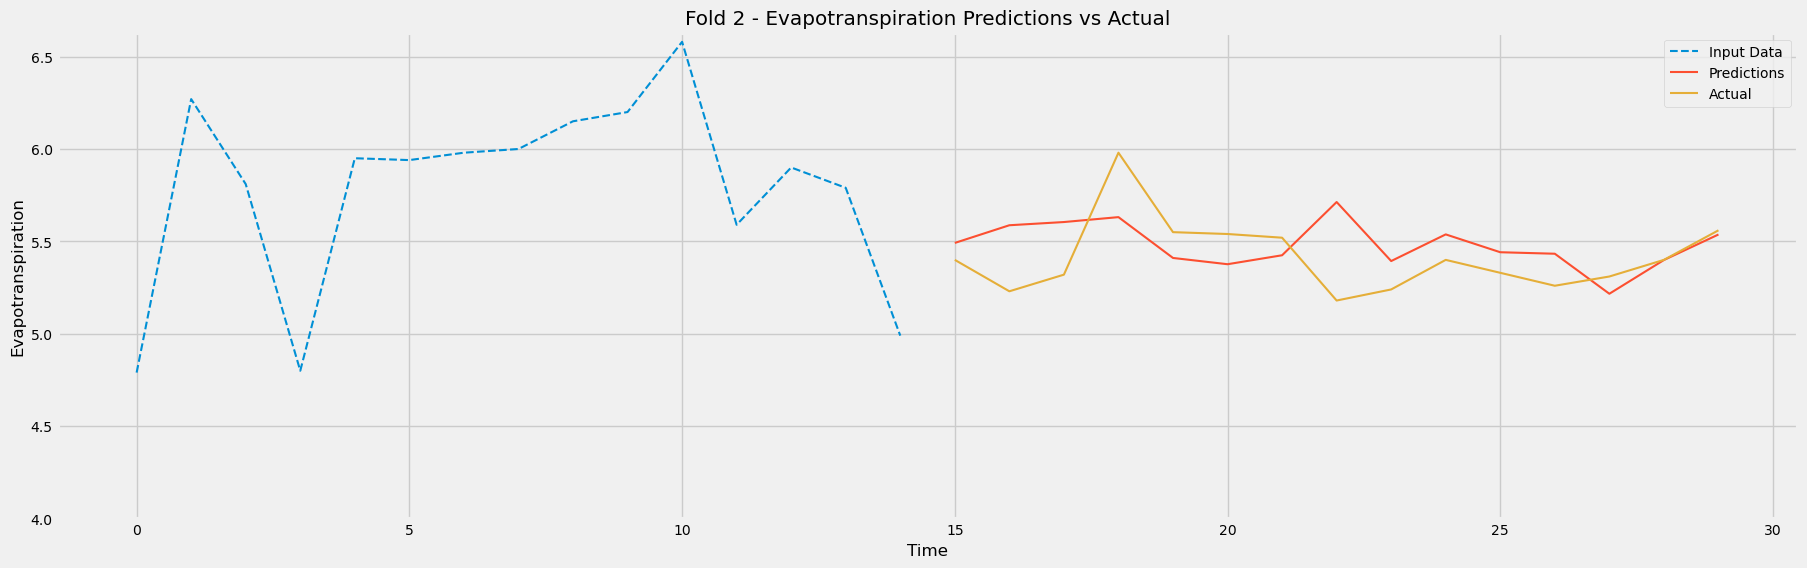

1/1 [==============================] - 0s 17ms/step - loss: 0.0013
Fold 3 - Test Loss: 0.0013413149863481522
1/1 [==============================] - 0s 14ms/step
Fold 3 - MSE: 0.051062396215098844
Fold 3 - MAE: 0.17653426361083976


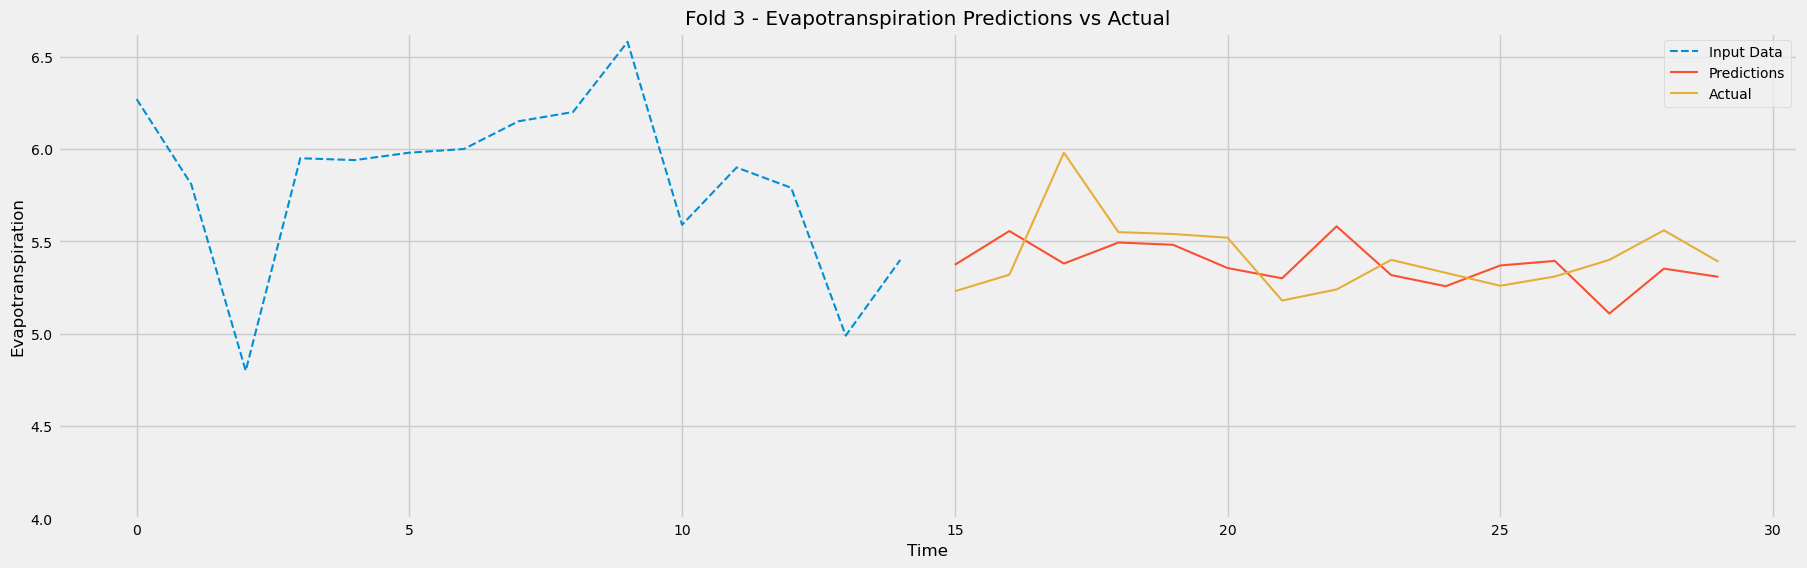

Average MSE: 0.05425584943877976
Average MAE: 0.1826944160461426


In [23]:
df = datos.copy()

num_features = df.shape[1]

# interpolate missing values
df = df.interpolate(method='linear', axis=0)

# remove all nan values
df = df.dropna()

# Get the minimum and maximum values of 'eto'
min_et = df['eto'].min()
max_et = df['eto'].max()

# Normalize data
scaled_data = df[df.columns].values

scalers = {}
for column in df.columns:
    scalers[column] = MinMaxScaler(feature_range=(0, 1))
    scaled_data[:, df.columns.get_loc(column)] = scalers[column].fit_transform(scaled_data[:, df.columns.get_loc(column)].reshape(-1, 1)).flatten()

# Prepare input and output sequences
n_days = 15  # Number of days in each sequence
X = []
y = []
for i in range(n_days, len(df) - n_days + 1):
    X.append(scaled_data[i-n_days:i])
    y.append(scaled_data[i:i+n_days, df.columns.get_loc('eto')])  # Output sequence with 7 days of Evapotranspiration


X = np.array(X)
y = np.array(y)

# Define the callbacks
early_stopping = EarlyStopping(patience=10, monitor='val_loss', mode='min', restore_best_weights=True)
# model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
lr_scheduler = LearningRateScheduler(lambda epoch: 0.001 * 0.9 ** epoch)  # Example learning rate scheduler


# Define LSTM model
model = keras.Sequential()
model.add(keras.layers.LSTM(32, activation='relu', input_shape=(n_days, X.shape[2])))
model.add(keras.layers.Dense(n_days))
model.compile(optimizer='adam', loss='mean_squared_error')

# Apply TimeSeriesSplit for cross-validation
mse_scores = []
mae_scores = []
tscv = TimeSeriesSplit(n_splits=3, test_size=1)  # Assuming you want to split the data into 5 folds
for fold, (train_index, test_index) in enumerate(tscv.split(X), 1):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler], verbose=0)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test)
    print(f"Fold {fold} - Test Loss: {loss}")

    # Make predictions
    predictions = model.predict(X_test)

    # Inverse transform the predictions and actual values
    inv_predictions = scalers['eto'].inverse_transform(predictions).flatten()
    inv_actual = scalers['eto'].inverse_transform(y_test).flatten()
    inv_input = scalers['eto'].inverse_transform(X_test[:, :, df.columns.get_loc('eto')].reshape(1, -1)).flatten()

    # Calculate MSE
    mse = mean_squared_error(inv_actual, inv_predictions)
    mse_scores.append(mse)
    print(f"Fold {fold} - MSE: {mse}")

    # Calculate MAE
    mae = np.mean(np.abs(inv_actual - inv_predictions))
    mae_scores.append(mae)
    print(f"Fold {fold} - MAE: {mae}")

    # Plot predictions, actual values, and input data
    plt.figure(figsize=(20, 6))
    plt.plot(np.arange(len(inv_input)), inv_input, label='Input Data', linestyle='--')
    plt.plot(np.arange(len(inv_input), len(inv_input) + len(inv_actual)), inv_predictions, label='Predictions')
    plt.plot(np.arange(len(inv_input), len(inv_input) + len(inv_actual)), inv_actual, label='Actual')
    plt.xlabel('Time')
    plt.ylabel('Evapotranspiration')
    plt.title(f'Fold {fold} - Evapotranspiration Predictions vs Actual')
    plt.ylim(4, max_et)  # Set y-axis limits
    plt.legend()
    plt.show()

# Calculate average MSE across all splits
print(f"Average MSE: {np.mean(mse_scores)}")
print(f"Average MAE: {np.mean(mae_scores)}")